In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn, tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import torchvision.utils as vutils


MODEL_E_PATH = "anime-64x64-e.pth"
MODEL_G_PATH = "anime-64x64-g.pth"
EXPORT_PATH = "raw-weights-anime-64x64"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
class AnimeFaceDataset(Dataset):

    def __init__(self, transform=None, target_transform=None):
        self.size = 64
        self.path = "../data/AnimeFace/64x64.raw"
        raw_bytes = np.fromfile(self.path, dtype=np.uint8)
        self.content = raw_bytes.reshape((60000, 3, 64, 64))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        #return 10000
        return 60000

    def __getitem__(self, i):
        return self.content[i].astype(np.float32) / 255.0


def load_data(dataset, plot=False):
    dataloader = DataLoader(
        dataset,
        batch_size=128,
        shuffle=True
    )
    for x in dataloader:
        print("Shape of x:", x.shape)
        break
    if plot:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(
            next(iter(dataloader)).to(device)[:64],
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                   interpolation='nearest')
        plt.show()
    return dataloader


In [3]:
LATENT = 64
DIMS_E = [32, 64, 64, 32]
DIMS_G = [64, 64, 64, 64, 64, 3, -1, -1]

# activation = nn.ReLU
activation = nn.SiLU

class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_E
        self.main = nn.Sequential(
            # 3 x 64x64
            nn.Conv2d(3, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            activation(inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            activation(inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            activation(inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            activation(inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], LATENT, 4, 1, 0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        dims = DIMS_G
        layers = [
            # LATENT
            nn.Linear(LATENT, dims[0]*4*4, bias=True),
            activation(inplace=True),
            nn.Unflatten(1, (dims[0], 4, 4)),
            nn.Conv2d(dims[0], dims[1], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            activation(inplace=True),
            # dims[1] x 4x4
            nn.ConvTranspose2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            activation(inplace=True),
            # dims[2] x 8x8
            nn.ConvTranspose2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            activation(inplace=True),
            # dims[3] x 16x16
            nn.ConvTranspose2d(dims[3], dims[4], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[4]),
            activation(inplace=True),
            # dims[4] x 32x32
            nn.ConvTranspose2d(dims[4], dims[5], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[5]),
            # nn.SiLU(inplace=True),
            # nn.Conv2d(dims[5], dims[6], 3, 1, 1, bias=False),
            # nn.SiLU(inplace=True),
            # nn.Conv2d(dims[6], 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # 3 x 64x64
        ]
        layers = [layer for layer in layers if layer is not None]
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


Shape of x: torch.Size([128, 3, 64, 64])
Encoder 165760
Encoder(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU(inplace=True)
    (12): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Flatten(start_

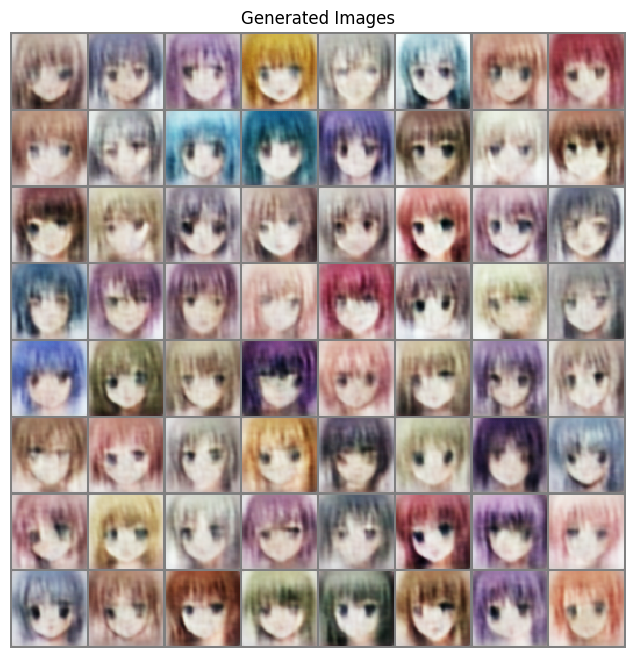

Epoch 2
[100/469]  loss: (l1=0.1222 ssim=0.5893 -> 0.6547) vae=0.1168 -> 0.7715
[200/469]  loss: (l1=0.1142 ssim=0.5642 -> 0.6169) vae=0.1127 -> 0.7297
[300/469]  loss: (l1=0.1147 ssim=0.5649 -> 0.6189) vae=0.1190 -> 0.7379
[400/469]  loss: (l1=0.1145 ssim=0.5721 -> 0.6207) vae=0.1128 -> 0.7334
Epoch 3
[100/469]  loss: (l1=0.1065 ssim=0.5446 -> 0.7375) vae=0.1112 -> 0.8488
[200/469]  loss: (l1=0.1075 ssim=0.5398 -> 0.7375) vae=0.1091 -> 0.8465
[300/469]  loss: (l1=0.1065 ssim=0.5433 -> 0.7365) vae=0.1114 -> 0.8479
[400/469]  loss: (l1=0.1031 ssim=0.5296 -> 0.7156) vae=0.1114 -> 0.8270
Epoch 4
[100/469]  loss: (l1=0.1020 ssim=0.5191 -> 0.8530) vae=0.1099 -> 0.9629
[200/469]  loss: (l1=0.1049 ssim=0.5224 -> 0.8650) vae=0.1122 -> 0.9773
[300/469]  loss: (l1=0.1019 ssim=0.5079 -> 0.8407) vae=0.1154 -> 0.9561
[400/469]  loss: (l1=0.1047 ssim=0.5261 -> 0.8683) vae=0.1176 -> 0.9859


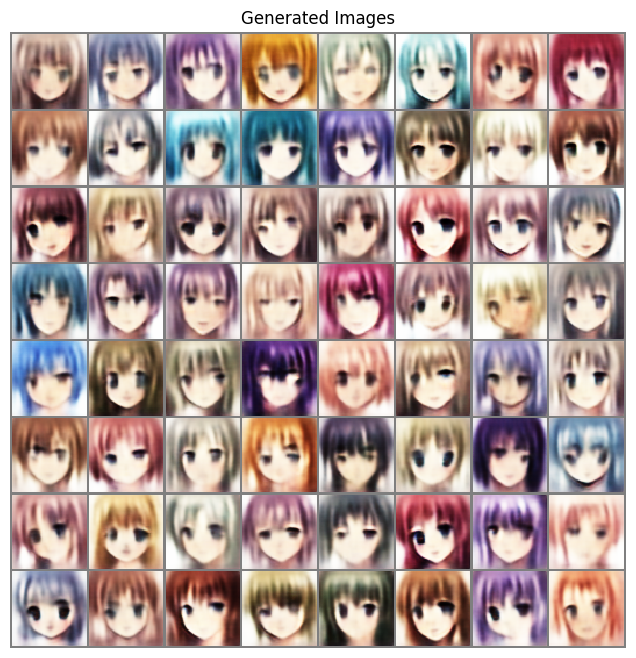

Epoch 5
[100/469]  loss: (l1=0.1034 ssim=0.5100 -> 0.9918) vae=0.1077 -> 1.0995
[200/469]  loss: (l1=0.1059 ssim=0.5060 -> 0.9927) vae=0.1134 -> 1.1061
[300/469]  loss: (l1=0.1020 ssim=0.5003 -> 0.9746) vae=0.1048 -> 1.0793
[400/469]  loss: (l1=0.1012 ssim=0.5000 -> 0.9719) vae=0.1104 -> 1.0822
Epoch 6
[100/469]  loss: (l1=0.1023 ssim=0.4913 -> 1.1007) vae=0.1057 -> 1.2064
[200/469]  loss: (l1=0.1028 ssim=0.4983 -> 1.1143) vae=0.1111 -> 1.2254
[300/469]  loss: (l1=0.1023 ssim=0.4918 -> 1.1016) vae=0.1178 -> 1.2195
[400/469]  loss: (l1=0.1038 ssim=0.4953 -> 1.1111) vae=0.1176 -> 1.2287
Epoch 7
[100/469]  loss: (l1=0.1035 ssim=0.4912 -> 1.2411) vae=0.1126 -> 1.3537
[200/469]  loss: (l1=0.1052 ssim=0.4857 -> 1.2326) vae=0.1108 -> 1.3434
[300/469]  loss: (l1=0.1032 ssim=0.4811 -> 1.2190) vae=0.1142 -> 1.3331
[400/469]  loss: (l1=0.1045 ssim=0.4834 -> 1.2264) vae=0.1082 -> 1.3346
Epoch 8
[100/469]  loss: (l1=0.1043 ssim=0.4699 -> 1.3271) vae=0.1173 -> 1.4444
[200/469]  loss: (l1=0.1054 ssim

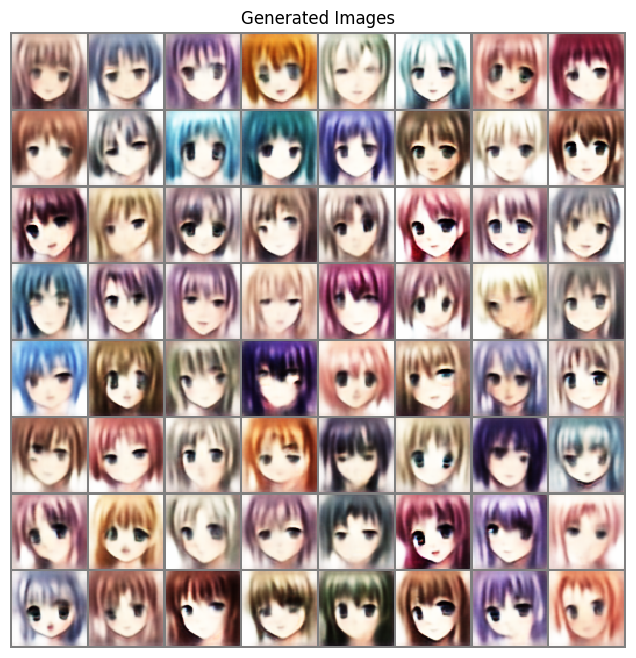

Epoch 10
[100/469]  loss: (l1=0.1078 ssim=0.4675 -> 1.5823) vae=0.1061 -> 1.6884
[200/469]  loss: (l1=0.1088 ssim=0.4626 -> 1.5674) vae=0.1080 -> 1.6755
[300/469]  loss: (l1=0.1083 ssim=0.4653 -> 1.5755) vae=0.1057 -> 1.6812
[400/469]  loss: (l1=0.1117 ssim=0.4658 -> 1.5798) vae=0.1026 -> 1.6825
Epoch 11
[100/469]  loss: (l1=0.1110 ssim=0.4615 -> 1.5656) vae=0.1104 -> 1.6760
[200/469]  loss: (l1=0.1117 ssim=0.4663 -> 1.5815) vae=0.1055 -> 1.6869
[300/469]  loss: (l1=0.1097 ssim=0.4531 -> 1.5376) vae=0.1037 -> 1.6413
[400/469]  loss: (l1=0.1075 ssim=0.4533 -> 1.5365) vae=0.1121 -> 1.6486
Epoch 12
[100/469]  loss: (l1=0.1083 ssim=0.4472 -> 1.5177) vae=0.1072 -> 1.6249
[200/469]  loss: (l1=0.1101 ssim=0.4513 -> 1.5323) vae=0.1087 -> 1.6410
[300/469]  loss: (l1=0.1166 ssim=0.4629 -> 1.5746) vae=0.1029 -> 1.6775
[400/469]  loss: (l1=0.1109 ssim=0.4513 -> 1.5329) vae=0.1075 -> 1.6404
Epoch 13
[100/469]  loss: (l1=0.1126 ssim=0.4627 -> 1.5706) vae=0.1039 -> 1.6745
[200/469]  loss: (l1=0.1143 

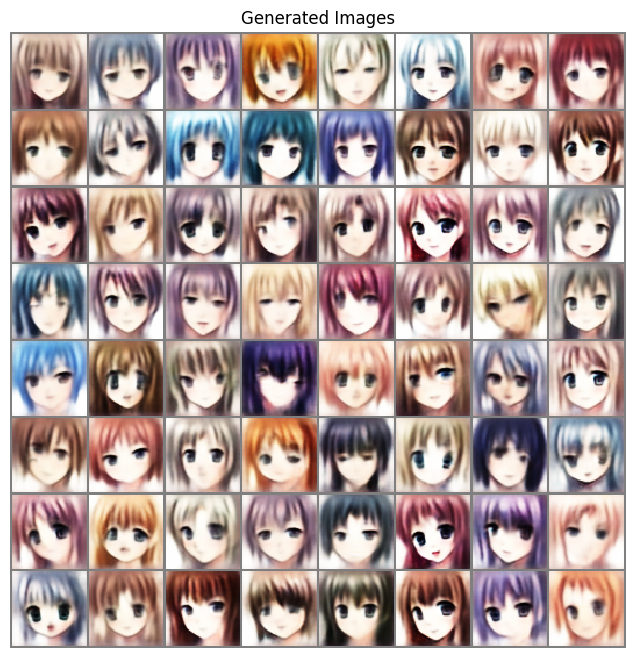

Epoch 17
[100/469]  loss: (l1=0.1099 ssim=0.4325 -> 1.4719) vae=0.1042 -> 1.5761
[200/469]  loss: (l1=0.1115 ssim=0.4465 -> 1.5182) vae=0.1064 -> 1.6246
[300/469]  loss: (l1=0.1134 ssim=0.4472 -> 1.5217) vae=0.1117 -> 1.6335
[400/469]  loss: (l1=0.1102 ssim=0.4418 -> 1.5019) vae=0.1061 -> 1.6081
Epoch 18
[100/469]  loss: (l1=0.1113 ssim=0.4367 -> 1.4864) vae=0.1048 -> 1.5912
[200/469]  loss: (l1=0.1131 ssim=0.4447 -> 1.5136) vae=0.1053 -> 1.6189
[300/469]  loss: (l1=0.1084 ssim=0.4351 -> 1.4792) vae=0.1039 -> 1.5831
[400/469]  loss: (l1=0.1074 ssim=0.4309 -> 1.4649) vae=0.1028 -> 1.5677
Epoch 19
[100/469]  loss: (l1=0.1120 ssim=0.4429 -> 1.5069) vae=0.1033 -> 1.6102
[200/469]  loss: (l1=0.1089 ssim=0.4389 -> 1.4915) vae=0.1071 -> 1.5986
[300/469]  loss: (l1=0.1120 ssim=0.4425 -> 1.5055) vae=0.1062 -> 1.6117
[400/469]  loss: (l1=0.1082 ssim=0.4301 -> 1.4628) vae=0.1107 -> 1.5734
Epoch 20
[100/469]  loss: (l1=0.1129 ssim=0.4411 -> 1.5020) vae=0.1043 -> 1.6063
[200/469]  loss: (l1=0.1121 

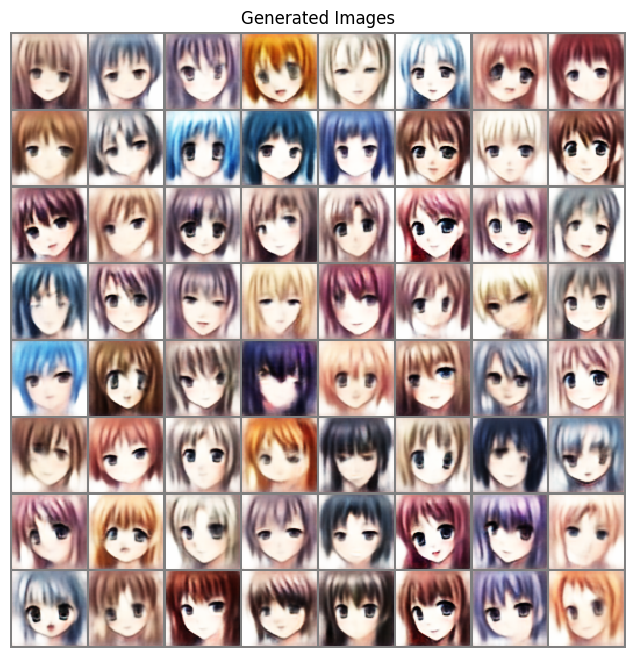

Epoch 26
[100/469]  loss: (l1=0.1125 ssim=0.4260 -> 1.4532) vae=0.1052 -> 1.5584
[200/469]  loss: (l1=0.1133 ssim=0.4260 -> 1.4539) vae=0.1093 -> 1.5633
[300/469]  loss: (l1=0.1096 ssim=0.4236 -> 1.4431) vae=0.1011 -> 1.5443
[400/469]  loss: (l1=0.1120 ssim=0.4282 -> 1.4598) vae=0.1094 -> 1.5692
Epoch 27
[100/469]  loss: (l1=0.1104 ssim=0.4298 -> 1.4638) vae=0.1035 -> 1.5673
[200/469]  loss: (l1=0.1122 ssim=0.4330 -> 1.4755) vae=0.0978 -> 1.5732
[300/469]  loss: (l1=0.1116 ssim=0.4261 -> 1.4528) vae=0.1087 -> 1.5615
[400/469]  loss: (l1=0.1080 ssim=0.4192 -> 1.4280) vae=0.1081 -> 1.5361
Epoch 28
[100/469]  loss: (l1=0.1100 ssim=0.4218 -> 1.4379) vae=0.1125 -> 1.5504
[200/469]  loss: (l1=0.1111 ssim=0.4256 -> 1.4507) vae=0.1072 -> 1.5579
[300/469]  loss: (l1=0.1096 ssim=0.4295 -> 1.4620) vae=0.1054 -> 1.5674
[400/469]  loss: (l1=0.1125 ssim=0.4344 -> 1.4802) vae=0.1058 -> 1.5860
Epoch 29
[100/469]  loss: (l1=0.1099 ssim=0.4189 -> 1.4284) vae=0.1021 -> 1.5305
[200/469]  loss: (l1=0.1107 

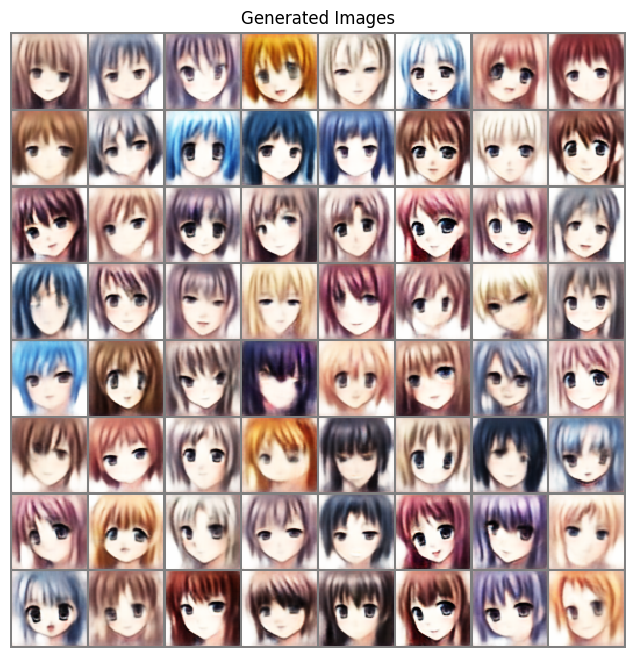

Epoch 37
[100/469]  loss: (l1=0.1112 ssim=0.4139 -> 1.4136) vae=0.1012 -> 1.5148
[200/469]  loss: (l1=0.1098 ssim=0.4221 -> 1.4387) vae=0.1090 -> 1.5477
[300/469]  loss: (l1=0.1103 ssim=0.4173 -> 1.4235) vae=0.1041 -> 1.5276
[400/469]  loss: (l1=0.1121 ssim=0.4234 -> 1.4446) vae=0.1048 -> 1.5494
Epoch 38
[100/469]  loss: (l1=0.1139 ssim=0.4157 -> 1.4212) vae=0.1020 -> 1.5232
[200/469]  loss: (l1=0.1097 ssim=0.4154 -> 1.4169) vae=0.1050 -> 1.5219
[300/469]  loss: (l1=0.1099 ssim=0.4223 -> 1.4393) vae=0.1036 -> 1.5429
[400/469]  loss: (l1=0.1098 ssim=0.4169 -> 1.4218) vae=0.1085 -> 1.5303
Epoch 39
[100/469]  loss: (l1=0.1145 ssim=0.4184 -> 1.4304) vae=0.1034 -> 1.5338
[200/469]  loss: (l1=0.1105 ssim=0.4173 -> 1.4237) vae=0.1019 -> 1.5256
[300/469]  loss: (l1=0.1085 ssim=0.4104 -> 1.4001) vae=0.1070 -> 1.5072
[400/469]  loss: (l1=0.1116 ssim=0.4197 -> 1.4322) vae=0.1034 -> 1.5356
Epoch 40
[100/469]  loss: (l1=0.1062 ssim=0.4007 -> 1.3673) vae=0.1076 -> 1.4749
[200/469]  loss: (l1=0.1119 

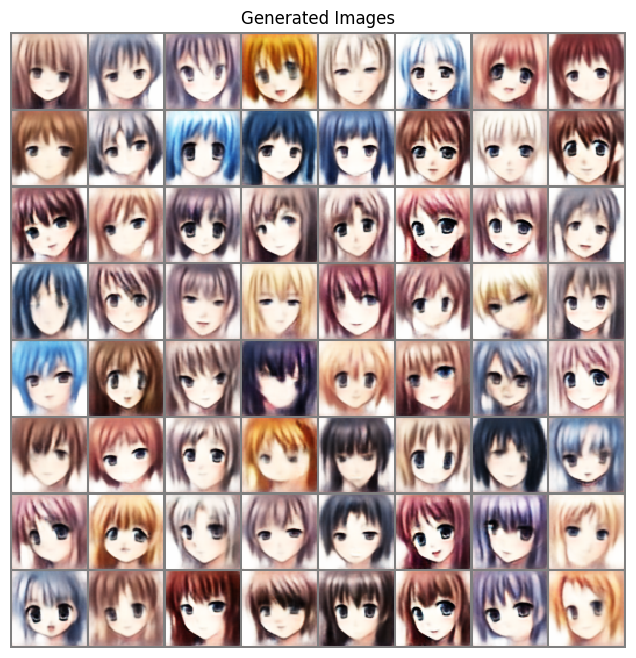

Epoch 50
[100/469]  loss: (l1=0.1105 ssim=0.4156 -> 1.4182) vae=0.1041 -> 1.5223
[200/469]  loss: (l1=0.1104 ssim=0.4058 -> 1.3870) vae=0.1047 -> 1.4917
[300/469]  loss: (l1=0.1055 ssim=0.3976 -> 1.3569) vae=0.1056 -> 1.4625
[400/469]  loss: (l1=0.1071 ssim=0.4010 -> 1.3688) vae=0.1084 -> 1.4772
Epoch 51
[100/469]  loss: (l1=0.1073 ssim=0.4109 -> 1.4007) vae=0.1070 -> 1.5077
[200/469]  loss: (l1=0.1079 ssim=0.4014 -> 1.3708) vae=0.1077 -> 1.4785
[300/469]  loss: (l1=0.1116 ssim=0.4177 -> 1.4259) vae=0.1074 -> 1.5333
[400/469]  loss: (l1=0.1076 ssim=0.4074 -> 1.3897) vae=0.1130 -> 1.5027
Epoch 52
[100/469]  loss: (l1=0.1112 ssim=0.4047 -> 1.3840) vae=0.1131 -> 1.4970
[200/469]  loss: (l1=0.1125 ssim=0.4142 -> 1.4153) vae=0.1047 -> 1.5199
[300/469]  loss: (l1=0.1095 ssim=0.4136 -> 1.4110) vae=0.1091 -> 1.5201
[400/469]  loss: (l1=0.1082 ssim=0.4026 -> 1.3750) vae=0.1053 -> 1.4803
Epoch 53
[100/469]  loss: (l1=0.1058 ssim=0.4008 -> 1.3672) vae=0.1041 -> 1.4714
[200/469]  loss: (l1=0.1120 

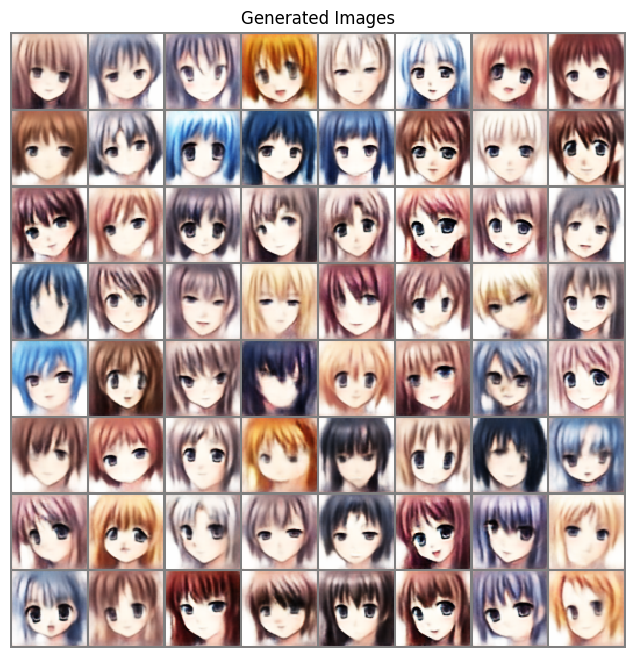

Epoch 65
[100/469]  loss: (l1=0.1085 ssim=0.3969 -> 1.3568) vae=0.1078 -> 1.4647
[200/469]  loss: (l1=0.1104 ssim=0.4063 -> 1.3885) vae=0.1069 -> 1.4954
[300/469]  loss: (l1=0.1092 ssim=0.4073 -> 1.3906) vae=0.1011 -> 1.4917
[400/469]  loss: (l1=0.1077 ssim=0.3956 -> 1.3521) vae=0.0993 -> 1.4514
Epoch 66
[100/469]  loss: (l1=0.1079 ssim=0.4071 -> 1.3890) vae=0.1026 -> 1.4916
[200/469]  loss: (l1=0.1095 ssim=0.4051 -> 1.3839) vae=0.1025 -> 1.4863
[300/469]  loss: (l1=0.1087 ssim=0.3987 -> 1.3629) vae=0.1018 -> 1.4647
[400/469]  loss: (l1=0.1098 ssim=0.4070 -> 1.3901) vae=0.1039 -> 1.4940
Epoch 67
[100/469]  loss: (l1=0.1103 ssim=0.4048 -> 1.3836) vae=0.1096 -> 1.4932
[200/469]  loss: (l1=0.1078 ssim=0.4069 -> 1.3882) vae=0.1034 -> 1.4917
[300/469]  loss: (l1=0.1095 ssim=0.4134 -> 1.4106) vae=0.0998 -> 1.5104
[400/469]  loss: (l1=0.1109 ssim=0.4066 -> 1.3899) vae=0.1048 -> 1.4947
Epoch 68
[100/469]  loss: (l1=0.1086 ssim=0.4012 -> 1.3708) vae=0.1069 -> 1.4777
[200/469]  loss: (l1=0.1071 

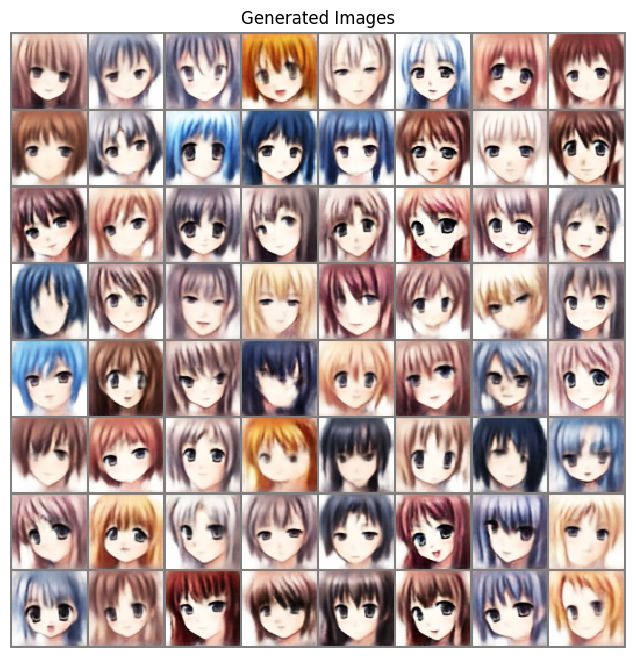

Epoch 82
[100/469]  loss: (l1=0.1092 ssim=0.3997 -> 1.3663) vae=0.1034 -> 1.4696
[200/469]  loss: (l1=0.1064 ssim=0.3891 -> 1.3302) vae=0.1075 -> 1.4378
[300/469]  loss: (l1=0.1070 ssim=0.4001 -> 1.3660) vae=0.1051 -> 1.4711
[400/469]  loss: (l1=0.1093 ssim=0.3992 -> 1.3648) vae=0.1026 -> 1.4674
Epoch 83
[100/469]  loss: (l1=0.1094 ssim=0.3921 -> 1.3422) vae=0.1022 -> 1.4444
[200/469]  loss: (l1=0.1111 ssim=0.4014 -> 1.3735) vae=0.1052 -> 1.4787
[300/469]  loss: (l1=0.1086 ssim=0.3953 -> 1.3519) vae=0.1019 -> 1.4538
[400/469]  loss: (l1=0.1101 ssim=0.3971 -> 1.3588) vae=0.1028 -> 1.4617
Epoch 84
[100/469]  loss: (l1=0.1082 ssim=0.3963 -> 1.3548) vae=0.1027 -> 1.4575
[200/469]  loss: (l1=0.1056 ssim=0.3934 -> 1.3433) vae=0.1094 -> 1.4527
[300/469]  loss: (l1=0.1105 ssim=0.4053 -> 1.3852) vae=0.1035 -> 1.4887
[400/469]  loss: (l1=0.1093 ssim=0.3951 -> 1.3519) vae=0.1099 -> 1.4619
Epoch 85
[100/469]  loss: (l1=0.1073 ssim=0.3942 -> 1.3473) vae=0.1006 -> 1.4479
[200/469]  loss: (l1=0.1077 

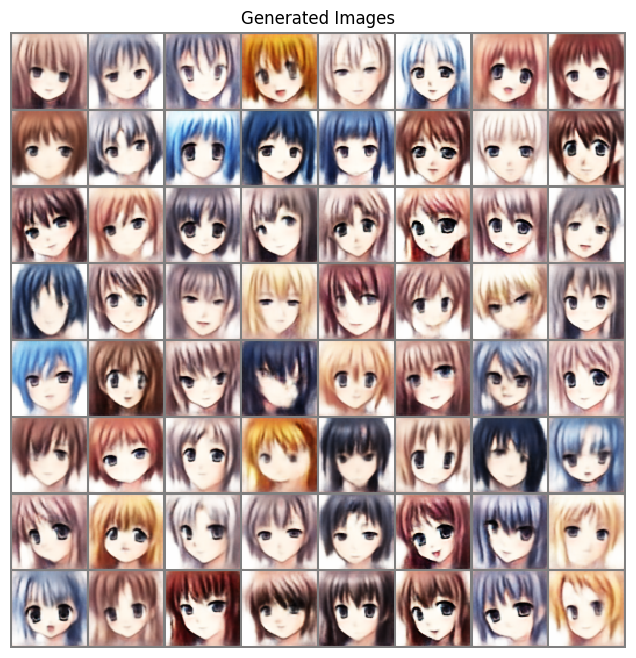

In [4]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


def weights_init(m):
    classname = m.__class__.__name__
    if 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif 'Linear' in classname:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.1)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.1)
    else:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.02)


def train_epoch(epoch, dataloader, net_e, net_g, loss_fn, optimizer_e, optimizer_g):

    net_e_params = torch.cat([x.view(-1) for x in net_e.parameters()])
    net_g_params = torch.cat([x.view(-1) for x in net_g.parameters()])

    for batch, x in enumerate(dataloader, 0):
        real = x.to(device)*2.0-1.0

        encoded = net_e(real)
        fake = net_g(encoded)

        # loss between real and fake
        loss_l1 = 0.5*torch.mean(torch.abs(fake-real))
        loss_ssim = 1 - ssim(0.5+0.5*real, 0.5+0.5*fake, data_range=1, size_average=True)
        ssim_t = 0.8 * np.clip((epoch-1)/(10-1), 0, 1)
        loss_diff = 4.0*((1-ssim_t)*loss_l1+ssim_t*loss_ssim)

        # KL divergence loss for VAE
        encoded_mean = torch.mean(encoded, axis=0)
        encoded_cov = torch.cov(encoded.T)
        p1 = torch.distributions.multivariate_normal.MultivariateNormal(
            encoded_mean, encoded_cov)
        p2 = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros_like(encoded_mean, device=device),
            torch.eye(LATENT, device=device))
        loss_vae = 0.01 * torch.distributions.kl_divergence(p1, p2)

        # train encoder/generator
        net_e.zero_grad()
        net_g.zero_grad()
        loss = loss_diff + loss_vae
        loss.backward()
        optimizer_e.step()
        optimizer_g.step()

        # output stats
        if (batch+1) % 100 == 0:
            print('[%d/%d]  loss: (l1=%.4f ssim=%.4f -> %.4f) vae=%.4f -> %.4f'
                  % (batch+1, len(dataloader),
                     loss_l1.item(),
                     loss_ssim.item(),
                     loss_diff.item(),
                     loss_vae.item(),
                     loss.item()))
            # break


def count_weights(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# load data
dataloader = load_data(AnimeFaceDataset())

# creat models
net_e = Encoder().to(device)
print("Encoder", count_weights(net_e))
print(net_e)

net_g = Generator().to(device)
print("Decoder", count_weights(net_g))
print(net_g)

try:
    net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
    net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
    print("Model loaded from file.")
except BaseException as e:
    net_e.apply(weights_init)
    net_g.apply(weights_init)
    print("Model weights initialized.")

# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer_e = torch.optim.Adam(net_e.parameters(),
                                lr=0.001, betas=(0.9, 0.999))
optimizer_g = torch.optim.Adam(net_g.parameters(),
                                lr=0.001, betas=(0.9, 0.999))

# train with progress
fixed_noise = torch.randn(64, LATENT, device=device)
for epoch in range(1, 100+1):
    # train
    print("Epoch", epoch)
    train_epoch(epoch, dataloader, net_e, net_g, loss_fn, optimizer_e, optimizer_g)
    # plot
    epoch_sqrt = int(epoch**0.5+1e-6)
    if epoch == epoch_sqrt**2:
        generated = net_g(fixed_noise)*0.5+0.5
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(
            generated,
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                    interpolation='nearest')
        plt.show() # on 

# export weights

torch.save(net_e.state_dict(), MODEL_E_PATH)
torch.save(net_g.state_dict(), MODEL_G_PATH)


In [5]:
param_i = 0
layers = {}
prev_class = None
prev_path = None
for layer in net_g.main:
    if layer.__class__.__name__ == "Linear":
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
        if len(list(layer.parameters())) > 1:
            data = list(layer.parameters())[1].data.cpu()
            shape = '_'.join(map(str, data.shape))
            path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
            layers[path] = data.numpy()
            prev_path = (prev_path, path)
    elif layer.__class__.__name__ in ['Conv2d', "ConvTranspose2d"]:
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()  # no bias
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ == "BatchNorm2d":
        assert len(layers[prev_path].shape) == 4
        mu = layer.running_mean.cpu()
        var = layer.running_var.cpu()
        invstdev = 1.0 / (var + 1e-5)**0.5
        data = list(layer.parameters())
        gamma, beta = data[0].data.cpu(), data[1].data.cpu()
        a = gamma * invstdev
        b = beta - mu * gamma * invstdev
        a, b = a.numpy(), b.numpy()
        # print(prev_class, layers[prev_path].shape, a.shape)
        if prev_class == 'ConvTranspose2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis]
        elif prev_class == 'Conv2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis, np.newaxis]
        # print(a.shape, b.shape, layers[prev_path].shape)
        shape = '_'.join(map(str, b.shape))
        path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
        layers[path] = b
    else:
        print(layer.__class__.__name__)
        prev_path = None
    prev_class = layer.__class__.__name__

for path, data in layers.items():
    data.astype(np.float32).tofile(path)

SiLU
Unflatten
SiLU
SiLU
SiLU
SiLU
Tanh


Shape of x: torch.Size([128, 3, 64, 64])
Model loaded from file.


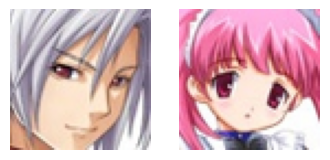

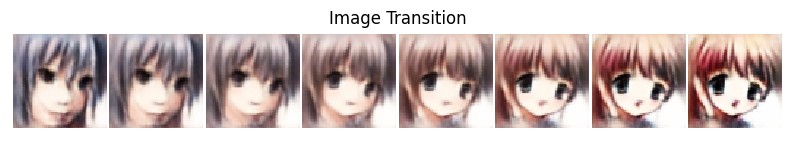

In [6]:
# load data
dataloader = load_data(AnimeFaceDataset())

# creat models
net_e = Encoder().to(device)
net_g = Generator().to(device)

net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
print("Model loaded from file.")

for batch in dataloader:
    img1 = batch[0:1]
    img2 = batch[1:2]
    # break

from PIL import Image
# img1 = torch.tensor([np.array(Image.open("/home/harry7557558/me.png").convert("RGB").resize((64,64)), dtype=np.float32)/255.0]).permute(0, 3, 1, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 10))
ax1.imshow(img1[0].permute(1, 2, 0))
ax2.imshow(img2[0].permute(1, 2, 0))
ax1.axis("off")
ax2.axis("off")
plt.show()

n = 8
enc1 = net_e(img1.to(device))
enc2 = net_e(img2.to(device))
t = torch.linspace(0, 1, n, device=device)
enc = enc1 + (enc2-enc1) * t[:, None]
img = net_g(enc)*0.5+0.5

plt.figure(figsize=(10, 30))
plt.axis("off")
plt.title("Image Transition")
plt.imshow(np.transpose(vutils.make_grid(
    img,
    padding=2, pad_value=1, normalize=True).cpu(), (1, 2, 0)),
            interpolation='nearest')
plt.show() # on ipynb
